In [1]:
import numpy as np
import math

from scipy import signal
from scipy.signal import lti 
from scipy.integrate import quad
import scipy.stats
from scipy.fft import fft , fftfreq ,fftshift

import matplotlib.pyplot as plt  # data plotting 
from matplotlib import rcParams

rcParams['figure.figsize']     = [15,6] 
rcParams['lines.markersize']   = 9         # marker size in points
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['figure.dpi']     = 180

In [2]:
def coloredhist(X,plot):
    Nbins = int(1 + 3.33*np.log2(len(X)))
    n, bins, patches = ax[1].hist(X, bins = Nbins )
    fracs = n / n.max()
    norm = colors.Normalize(fracs.min(), fracs.max())
    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)
    ax[1].hist(X, bins=Nbins,weights=weight, density=True) 
    plt.grid()
    return

In [3]:
# smoothing by a RC low-band pass filter
def RC_LowBand(N,y,time):
    # smoothing filter parameters
    R = 3000; C = .0003 ; τ = R*C  # time constant 
    f_c = 1/(2*np.pi*τ)               # Cutoff frequency
    num = [1]
    den = [τ, 1]
    
    # filter response
    lti_system = lti(num, den)
    t, h = lti_system.impulse(N)  
    coeff = fftshift(fft(h))
    # transfer function
    f = fftshift(fftfreq(coeff.shape[0],t[1]-t[0]))
    _,output0_,_ = lti_system.output(y, time)
    return f, coeff,output0_, f_c
    

In [4]:
# normalization [0,1]
def norMaxMin(data):
    min_value = np.min(data)
    max_value = np.max(data)
    return (data - min_value) / (max_value - min_value)

$\{a_i: i{\in}Nsymbols\}$,  $a_i(\delta t)= a_i, \,\forall \delta t {\in} Nsamples $

In [5]:
#Symbol Data Generation
    # symbol values {a0, a1}
a1 = 1       # symbol a1
a0 = 0      # symbol a0
A = [a0,a1]
Nsamples = 512  # time samples per symbol
    # symbol probability
p_0 = 0.78;   p_1 = 1 - p_0

    # symbol set
Nsymbols = 256
                # sample set
N = Nsymbols*Nsamples 
data    = np.random.choice([a0, a1], size=Nsymbols, p=[p_0, p_1])
message    = np.concatenate([[v]*Nsamples for v in data])
weight = np.ones_like(message)/N

$\eta \sim \mathcal{N}(0,\sigma^{2}),$

In [6]:
# Zero-mean Gaussian noise
time = np.linspace(0,N,N)

σ2 = np.pi/8 # Noise variance
σ2 = 10
noise = np.random.normal(0, σ2, N)

(-31.41592653589793, 31.41592653589793)

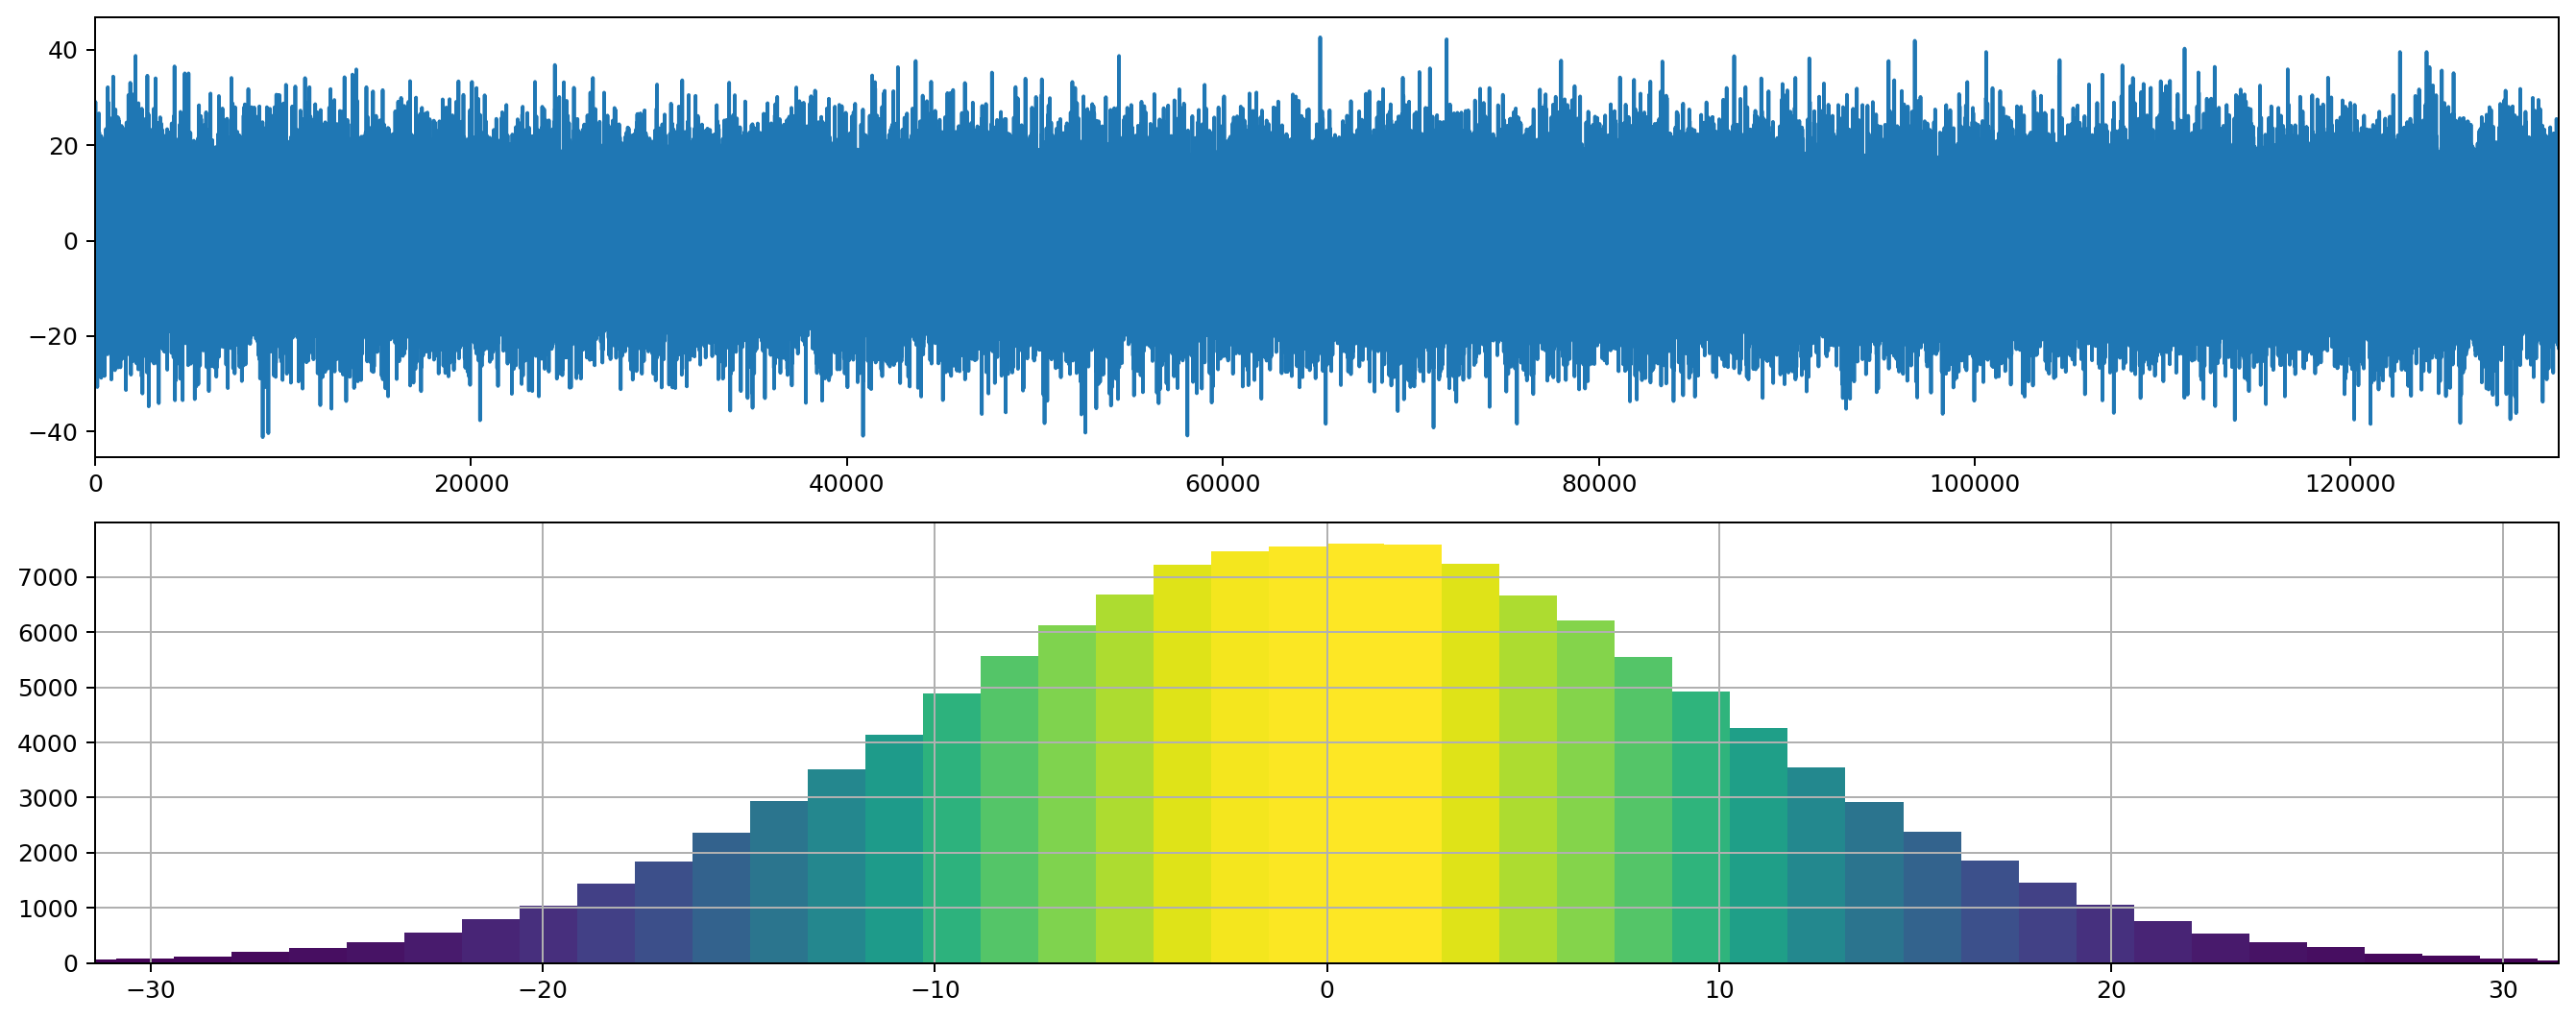

In [7]:
from matplotlib import colors

fig, ax = plt.subplots(2, 1, tight_layout=True)
ax[0].step(time,message, '-',color='blue',alpha=0.21) 
ax[0].set_xlim(0,len(message))

Nbins = int(1 + 3.322*np.log2(len(data)))
ax[0].plot(time,noise)
ax[1].hist(message, bins=Nbins,  density=True)
coloredhist(noise,plot=1)
plt.xlim(-σ2*np.pi,σ2*np.pi)

$y(t) = a_i + \eta(t)$

In [8]:
y =  message + noise # corrupted signal

#### Optimal ML threshold for binary detection
$\gamma_{\operatorname{opt}} =\frac{{\mu_1}^{2}-{\mu_0}^{2}+2{\sigma^{2}}\ln ( P(a_0)/P(a_1) )}{2(\mu_1-\mu_0)}$

In [9]:
γ  = .5*(a1*a1-a0*a0+2* σ2*np.log(p_0/p_1))/(a1-a0) 
counts, bin_edges = np.histogram(y, bins=Nbins)

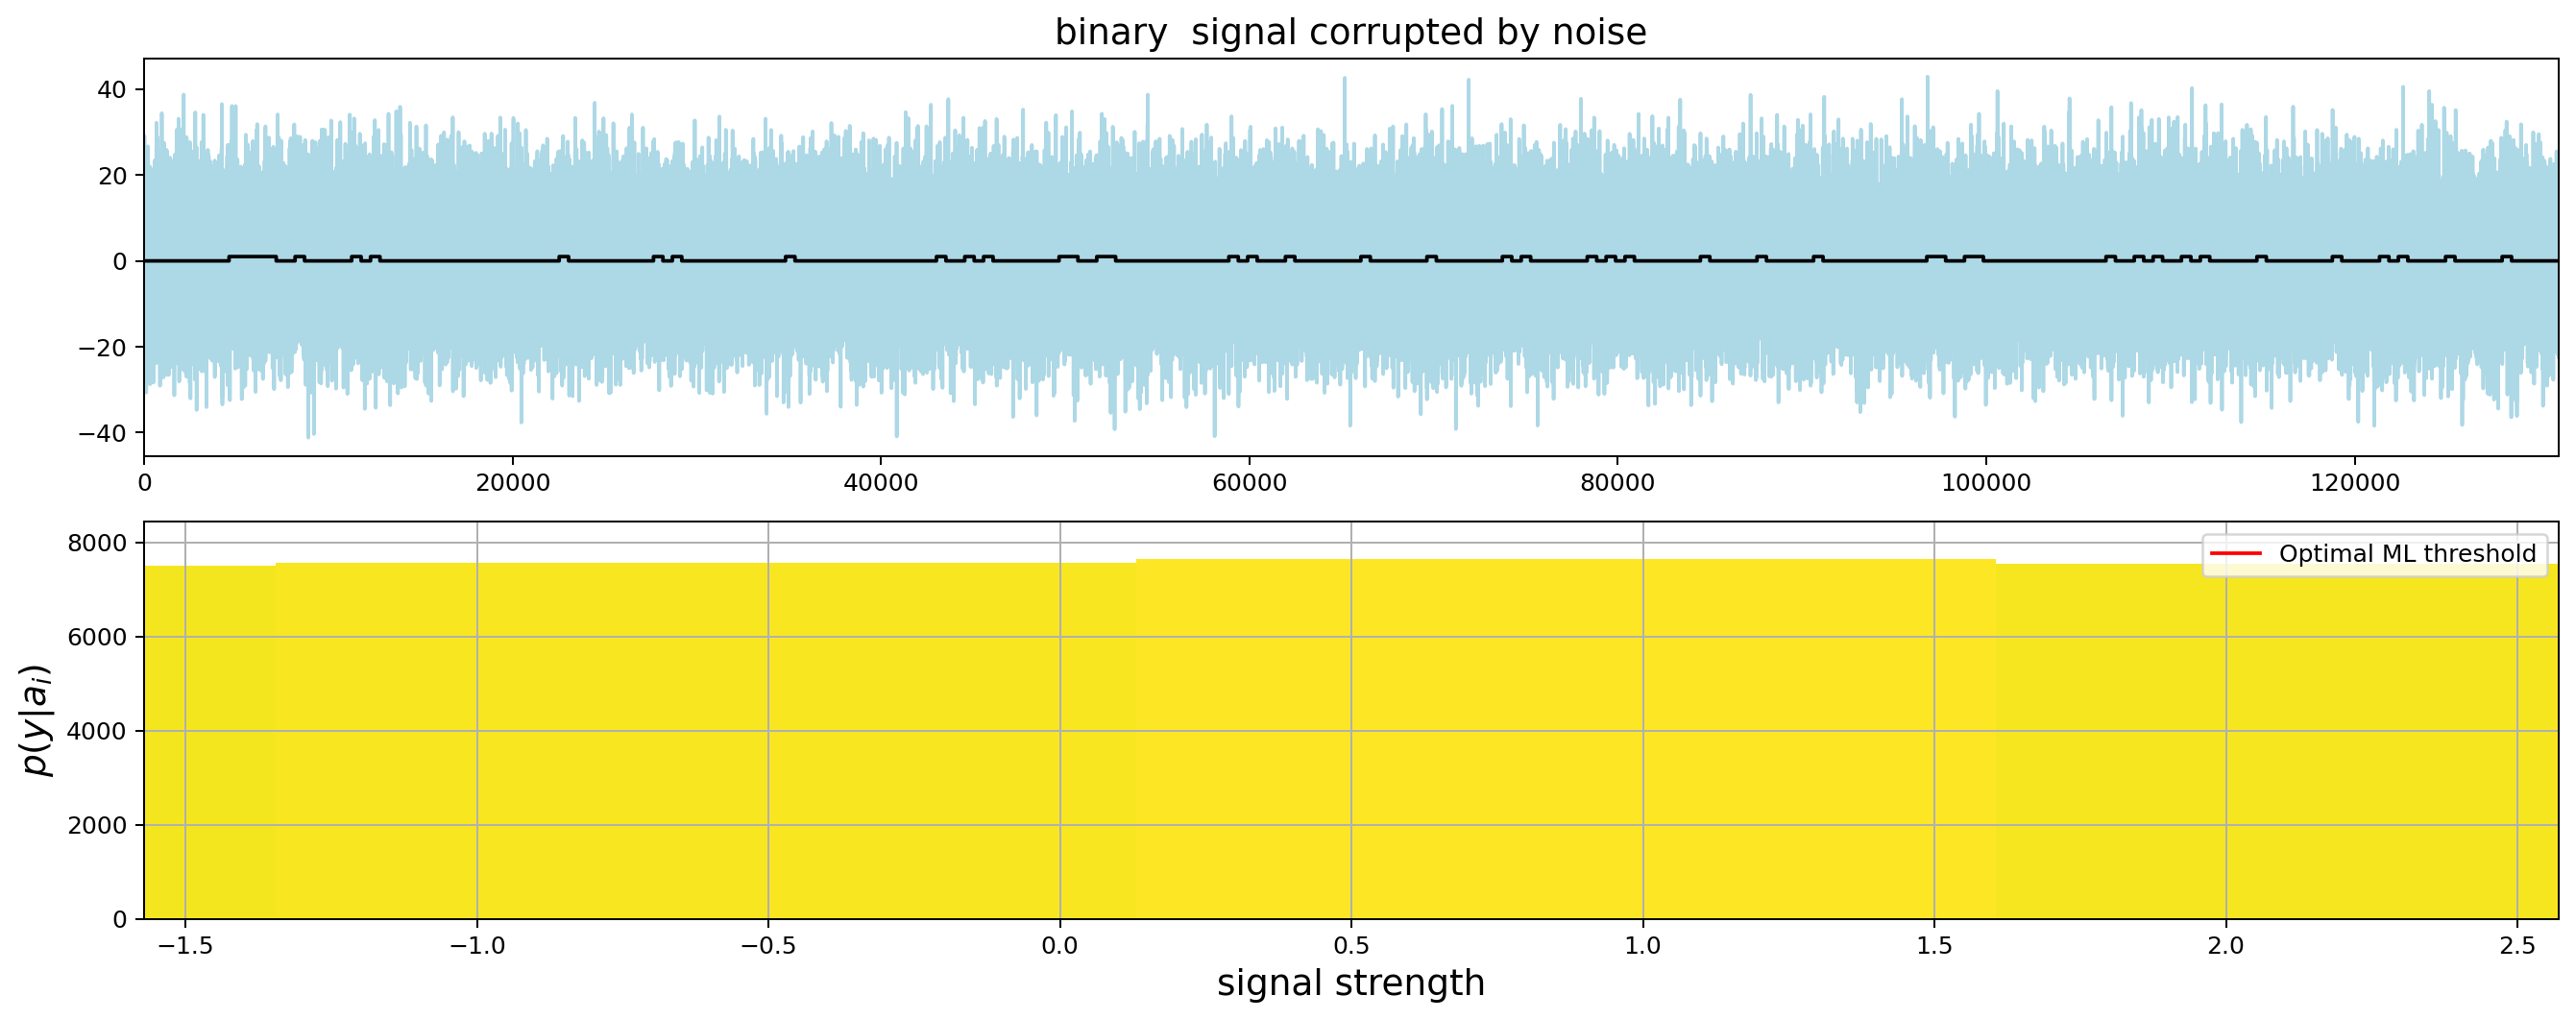

In [10]:
fig, ax = plt.subplots(2, 1, tight_layout=True)
ax[0].step(time,y, '-',color='lightblue') 
ax[0].step(time,message,color='k') 
ax[0].set_title('binary  signal corrupted by noise')
ax[0].set_xlim(0,N)
coloredhist(y,plot=1)
plt.ylabel(r"$p(y\vert a_i)$")
plt.xlabel("signal strength")
plt.xlim(-np.pi/2 +a0, a1+np.pi/2)
plt.plot([γ,γ],[0,max(counts)/2],color='red', label = 'Optimal ML threshold')
plt.legend()
plt.show()

Signal Filtering

In [11]:
f, coeff, y_fil, f_c = RC_LowBand(N,y, time)

/home/jony/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


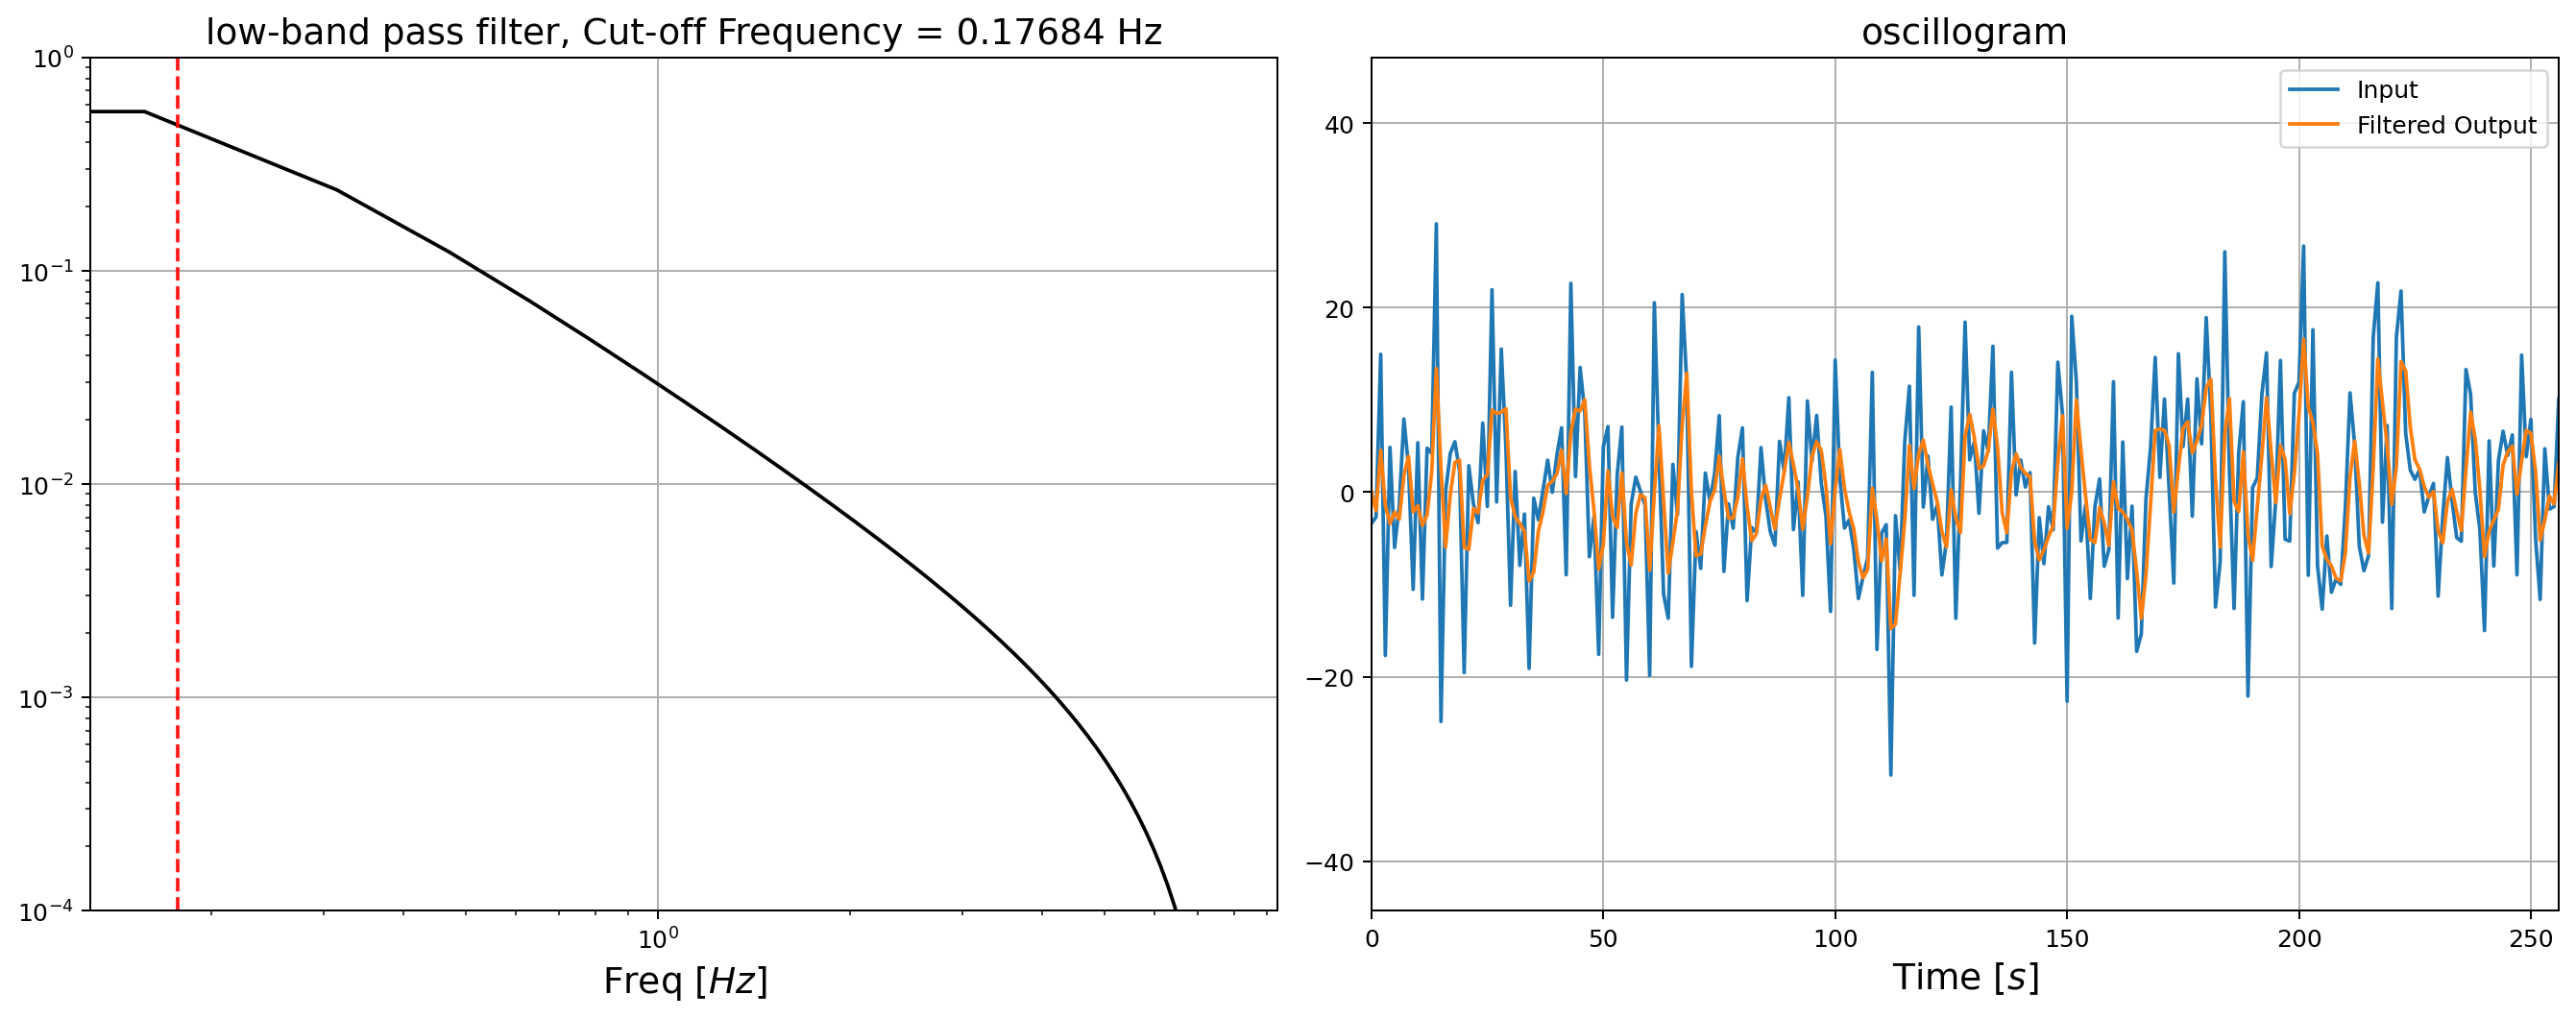

In [12]:
fig, ax = plt.subplots(1, 2, tight_layout=True)
ax[0].set_title(r'low-band pass filter, Cut-off Frequency = %.5f'%(f_c)+str(' Hz'))
ax[0].loglog(f,norMaxMin(coeff),'k')
ax[0].set_xlabel('Freq [$Hz$]')
ax[0].set_ylim(10e-5,1)
ax[0].axvline(f_c, color='r', linestyle='--',alpha=0.9)
ax[0].grid()

ax[1].plot(time, y, label='Input')
ax[1].plot(time, y_fil, label='Filtered Output')
ax[1].set_title('oscillogram')
ax[1].set_xlim(0,Nsamples/2)
ax[1].set_xlabel('Time [$s$]')
ax[1].legend()
ax[1].grid()

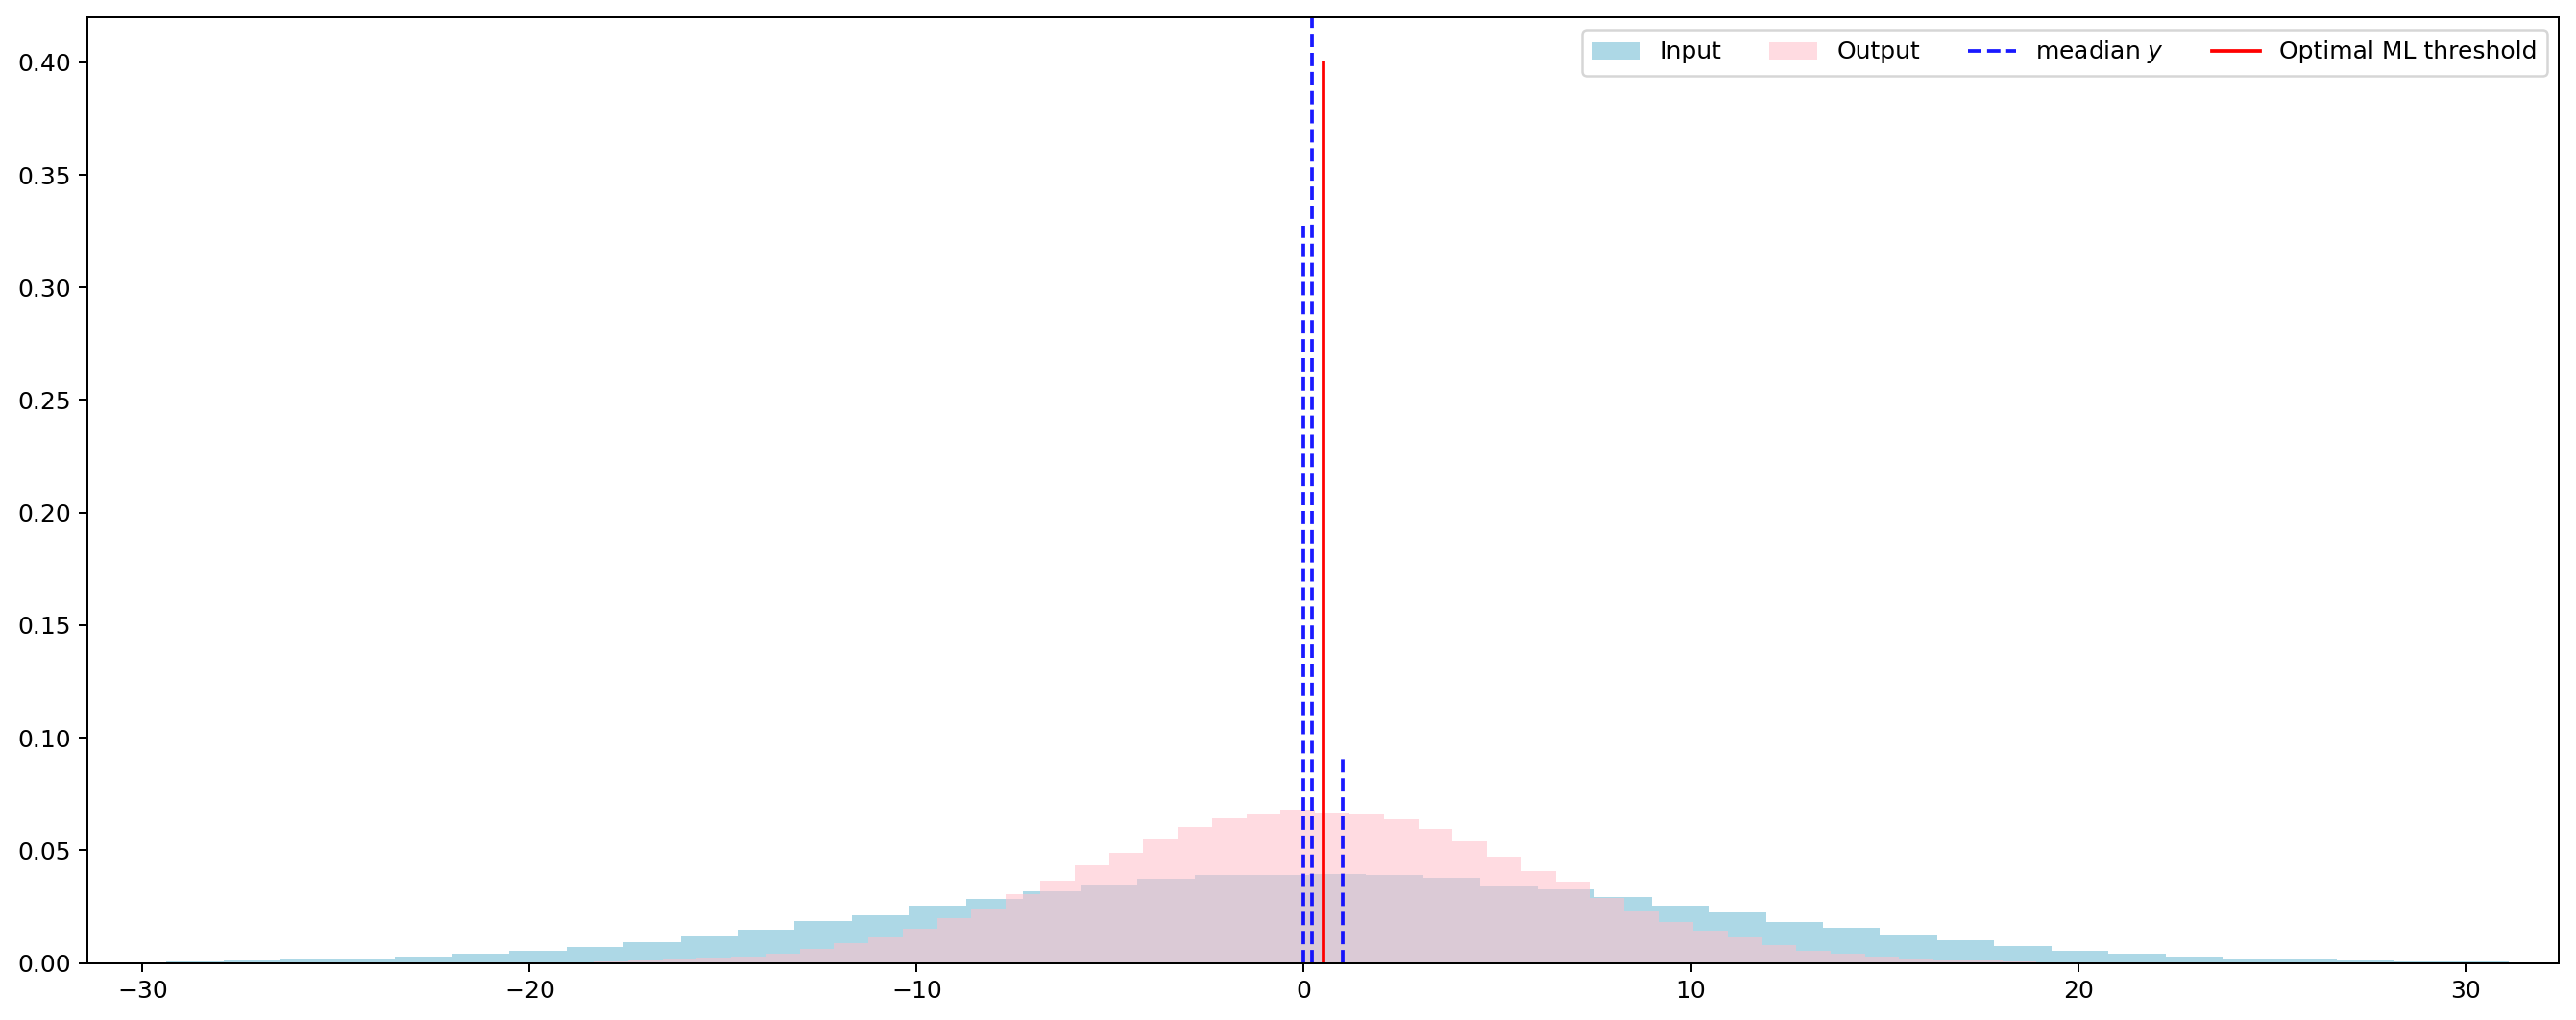

In [13]:
Nbins  = int(1 + 3.322*np.log2(len(message)))
plt.hist(y, bins = Nbins, color='lightblue',label='Input', density=True)
_,y_range,_ = plt.hist(y_fil, bins = Nbins, color='pink',label='Output',alpha=.57, density=True)
plt.axvline(a0, color='b', linestyle='--',alpha=0.9, ymax= p_0)
plt.axvline(a1, color='b', linestyle='--',alpha=0.9, ymax= p_1)
plt.axvline(np.median(y), color='b', label='meadian $y$',linestyle='--',alpha=0.9)
plt.plot([(a0+a1)/2,(a0+a1)/2],[0,.4],color='red', label = 'Optimal ML threshold')
plt.xlim(-σ2*np.pi+a0,σ2*np.pi+a1)
plt.legend(ncols=4)
# Tweak spacing to prevent clipping of ylabel
plt.tight_layout()
plt.show()

as $\sigma\to 0$, then $\gamma_{\operatorname{opt}} =\frac{{\mu_1}^{2}-{\mu_0}^{2}+2{\sigma^{2}}\ln ( P(a_0)/P(a_1) )}{2(\mu_1-\mu_0)}\sim \Large \frac{{\mu_1}+{\mu_0}}{2}$

In [14]:
γ_fil = (a0+a1)/2

$\lambda(y(\delta t),y( 2\delta t)),\ldots, y( k\delta t)),\ldots,y(Nsamples\;\delta t))\to \Large\lambda(\mathbb{E}\{k\delta t{:}\forall k\})$

(0.0, 256.0)

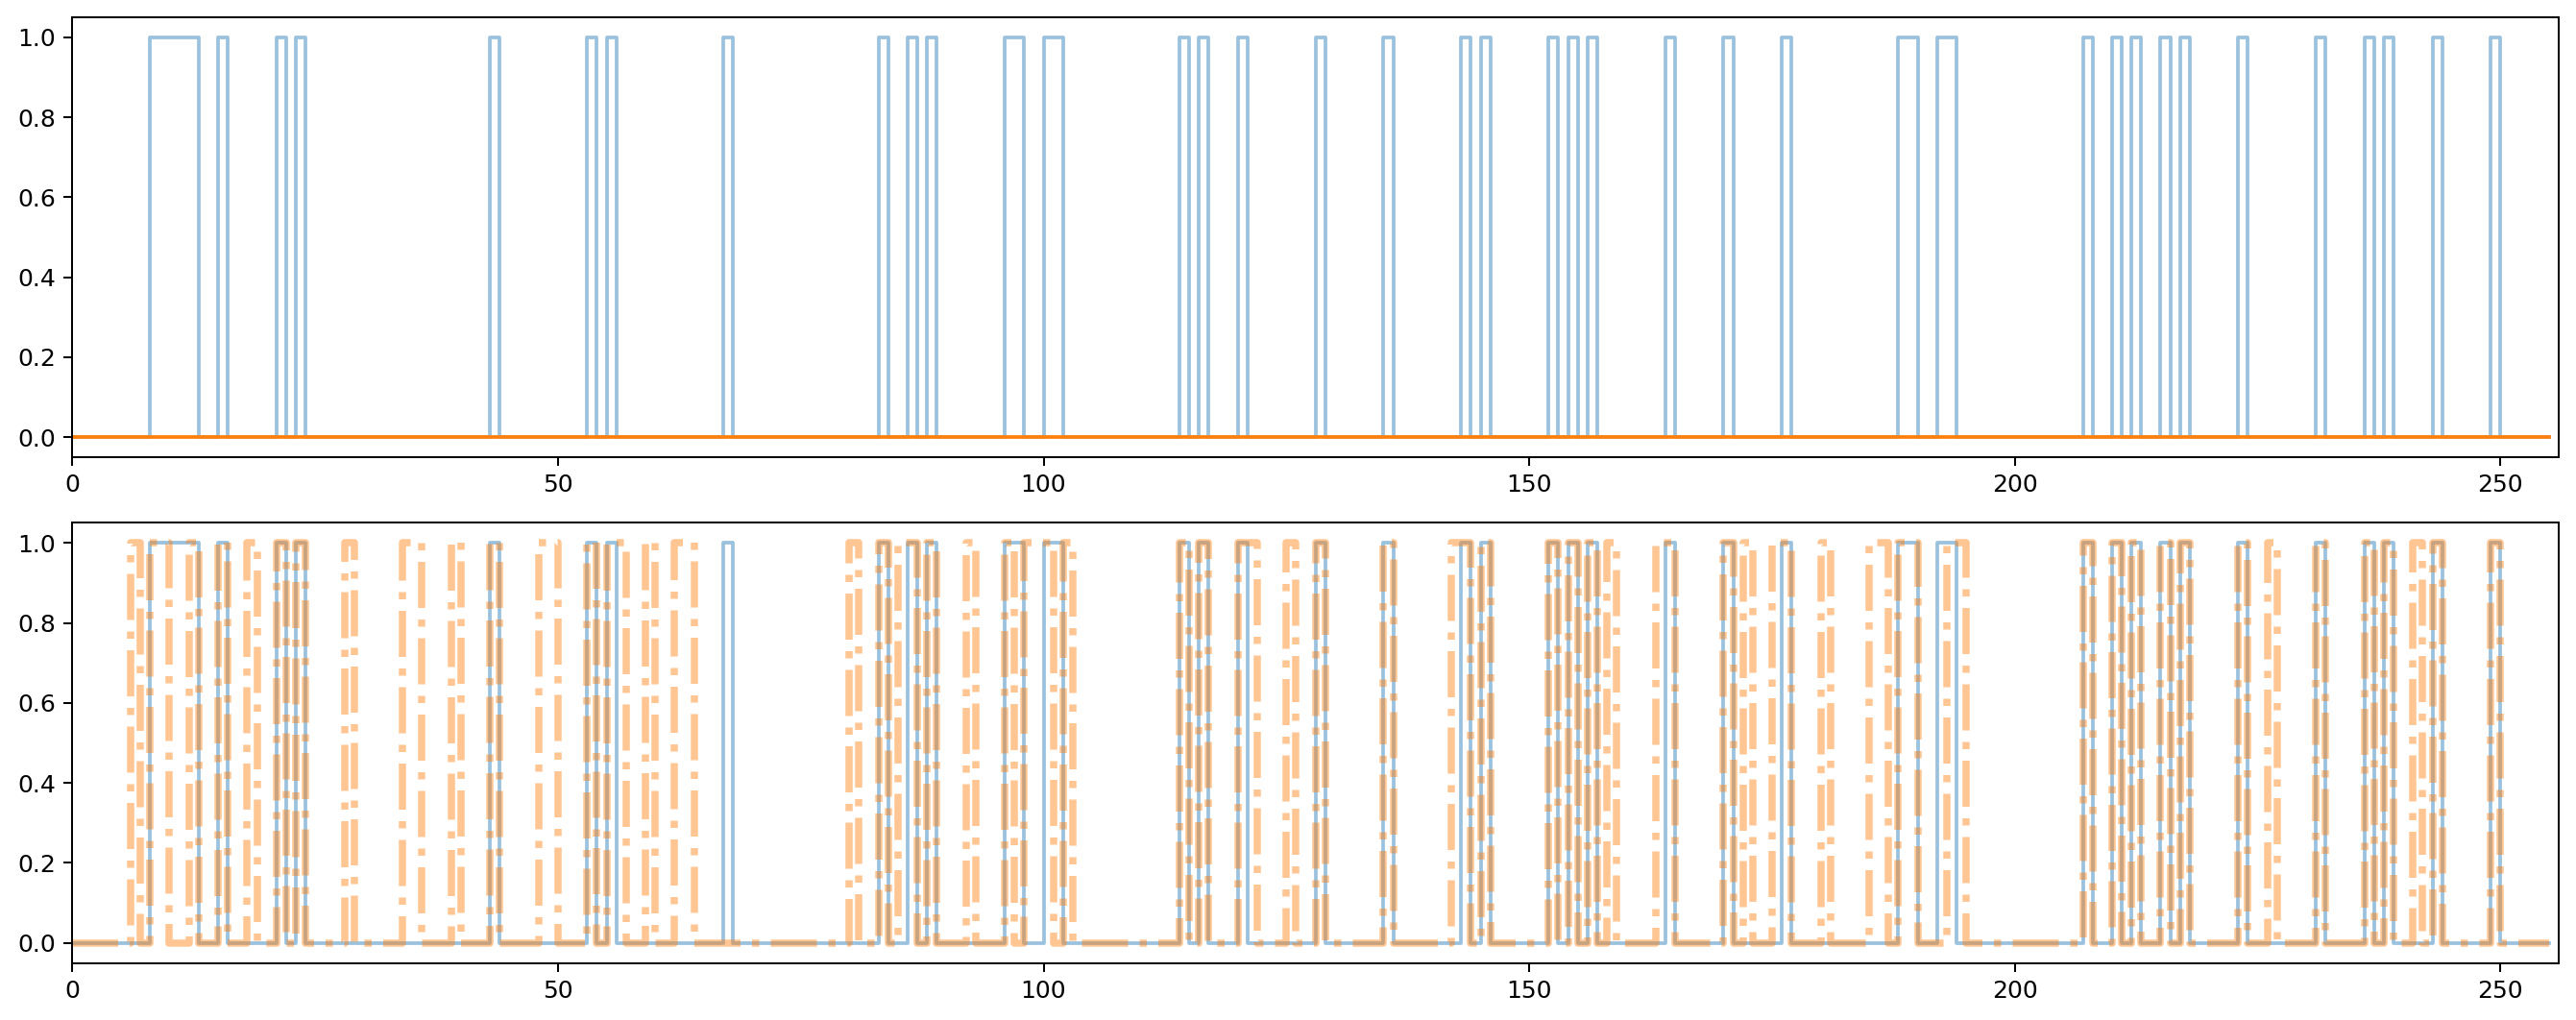

In [15]:
data_est = []; data_est_fil = []
for δt in range(0, N,Nsamples):
    y_mean = sum(y[δt:δt+Nsamples])/Nsamples
    y_mean_fil = sum(y_fil[δt:δt+Nsamples])/Nsamples
    a_est = a0 ; a_est_fil = a0 
    if y_mean> γ:
        a_est = a1
    if y_mean_fil> γ_fil:
        a_est_fil = a1
    data_est.append(int(a_est))
    data_est_fil.append(int(a_est_fil))

fig, ax = plt.subplots(2, 1, tight_layout=True)
ax[0].step(time[:len(data)],data, alpha=0.45)
ax[0].step(time[:len(data)],data_est)
ax[0].set_xlim(0,len(data))

ax[1].step(time[:len(data)],data, alpha=0.45)
ax[1].step(time[:len(data)],data_est_fil, linestyle='-.',alpha=0.45, linewidth=3)
ax[1].set_xlim(0,len(data))

In [16]:
# Using scipy to Calculate the Hamming Distance
from scipy.spatial.distance import hamming
print('P_e =', 1-hamming(data, data_est), ', P_efil =', 1-hamming(data, data_est_fil),)

P_e = 0.81640625 , P_efil = 0.85546875


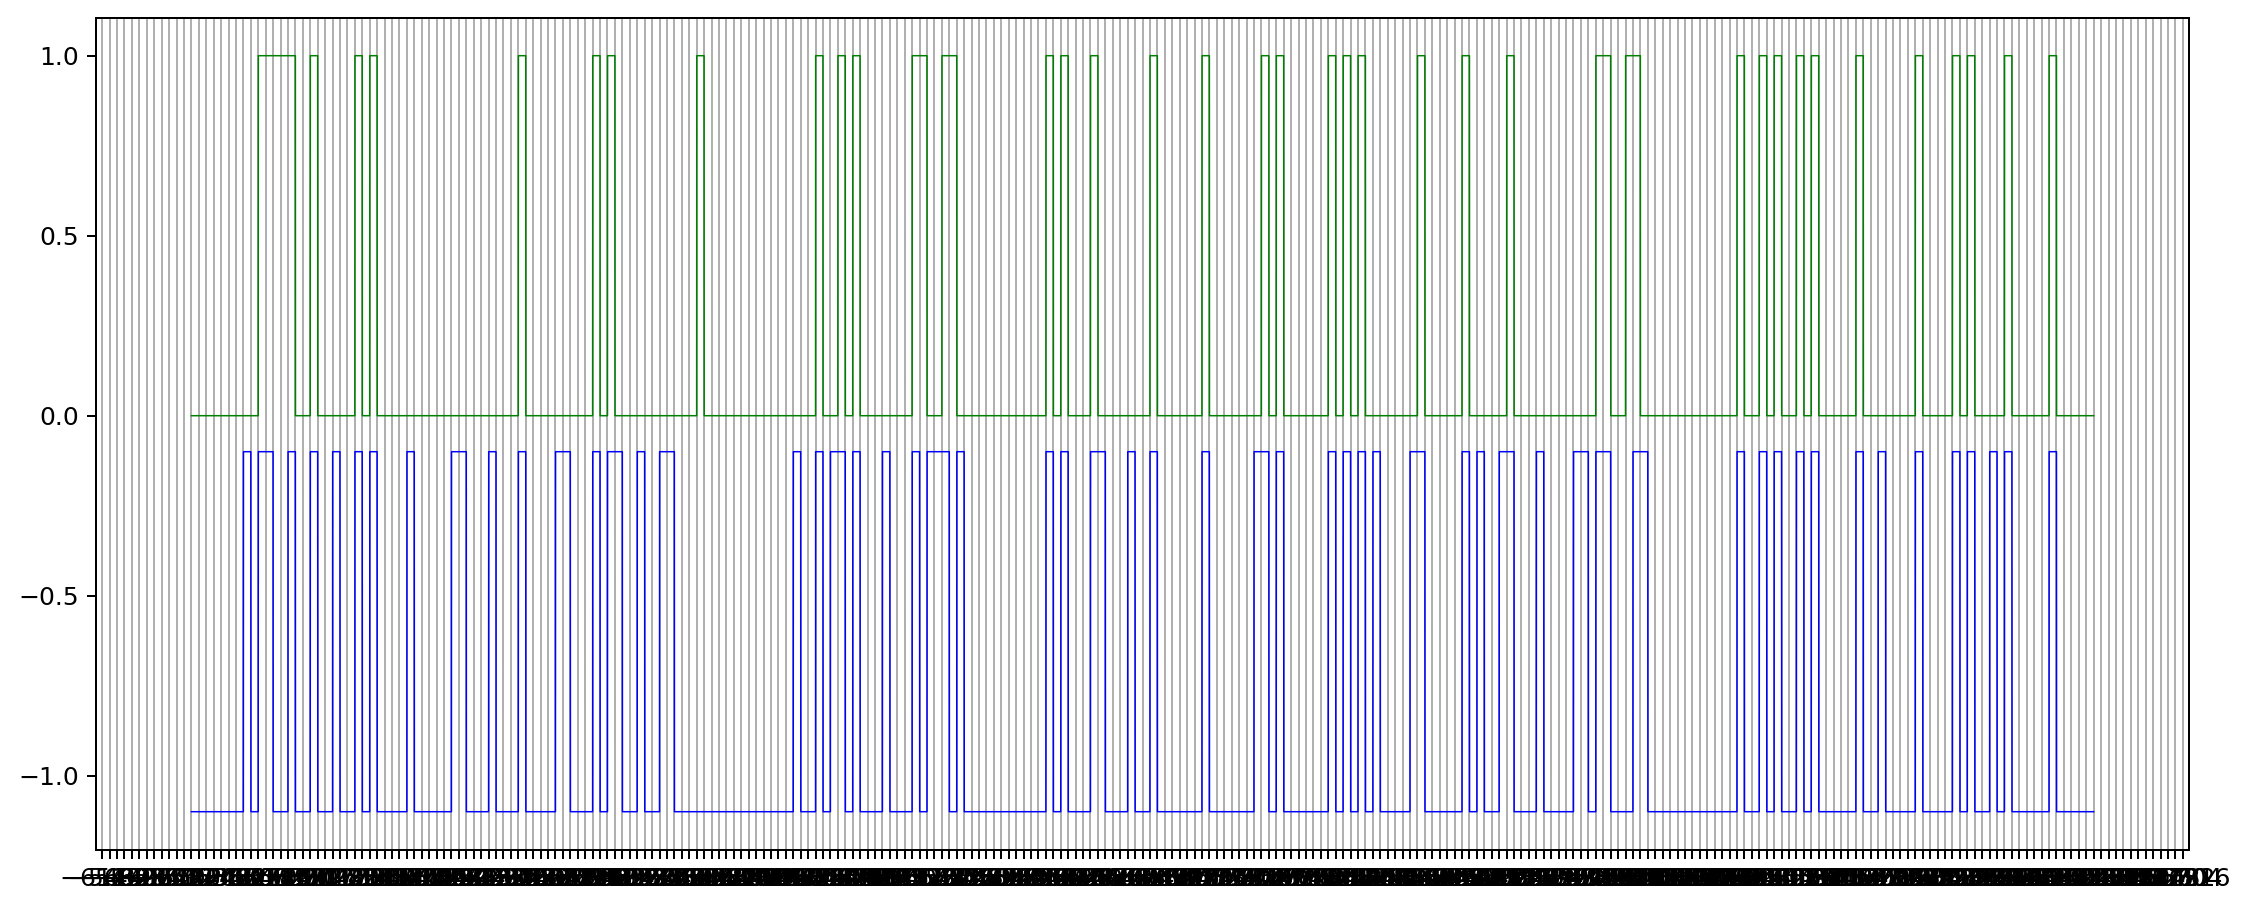

In [17]:
signal_detection = []

for i in range(0, N, Nsamples):
    prom = sum(y_fil[i:i+Nsamples])/Nsamples
    signal_detection.append(prom)

signal_detection = np.array(signal_detection)
signal_detection = signal_detection.repeat(Nsamples)
signal_detection = np.where(signal_detection >= 0.5, a1, a0)
signal_detection = signal_detection-1.1


#plt.plot(message, color = "green",linewidth=1, alpha=0.7)
plt.plot(message, color='green', linewidth=0.6)
plt.plot(signal_detection, color="blue", linewidth=0.6, alpha=1)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(Nsamples))
plt.grid(axis='x')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ae869be4-fccf-425b-9969-dad6f89a7d44' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

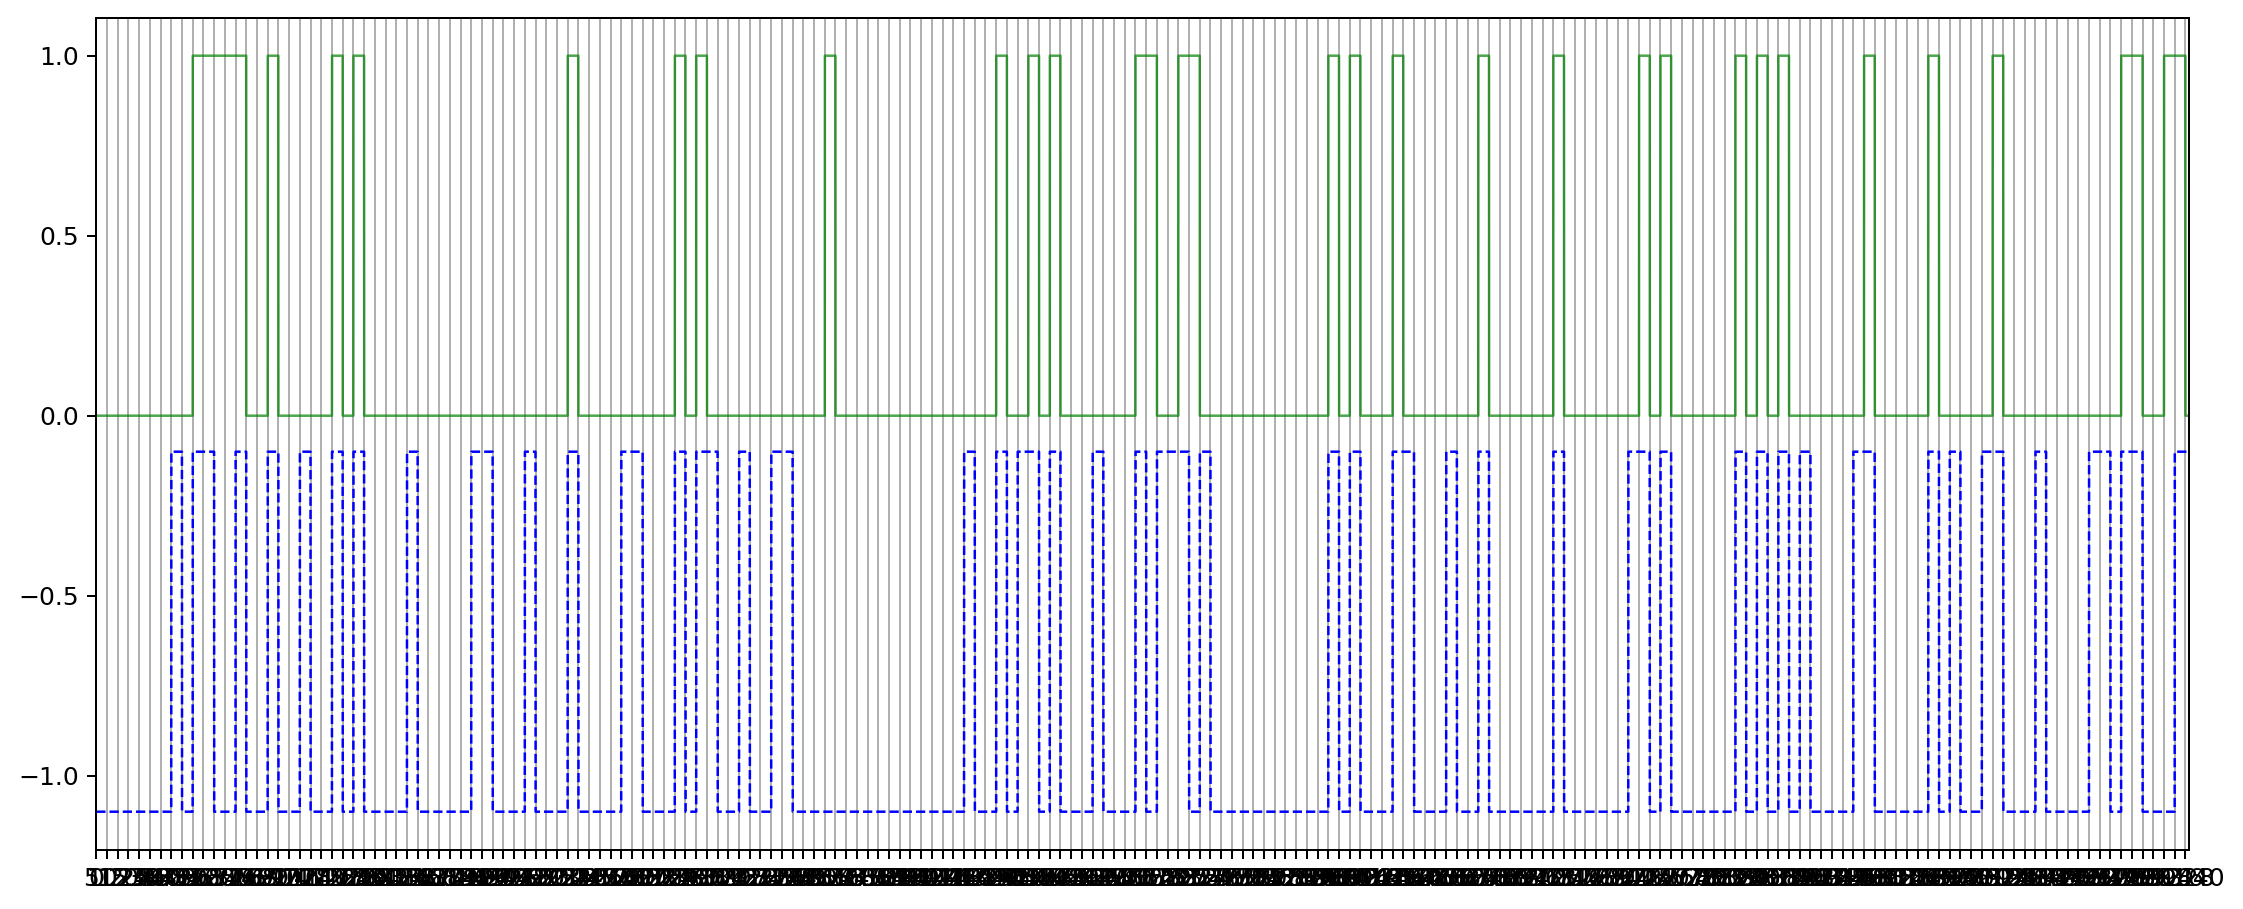

In [18]:
#metodo por distancia euclideana manual
signal_detection = []

for i in range(0, N, Nsamples):
    simbol = y_fil[i:i+Nsamples]

    #distance euclidean to simbol a0
    distance_a0 = np.sqrt(sum([(x-a0)**2 for x in simbol]))
    distance_a1 = np.sqrt(sum([(x-a1)**2 for x in simbol]))

    if distance_a0 < distance_a1:
        signal_detection.append(a0)
    else:
        signal_detection.append(a1)

signal_detection = np.repeat(signal_detection,Nsamples)
signal_detection = signal_detection - 1.1

plt.plot(message, color = "green",linewidth=1, alpha=0.7)
plt.plot(signal_detection, "--b", linewidth=1, alpha=1)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(Nsamples))
plt.grid(axis='x')
plt.xlim(0,100000)
plt.show()
